# Demonstration of subsampling feature dimensions

In [1]:
import pandas as pd
import openensembles as oe
import matplotlib.pyplot as plt

## Lu (2005) mRNA 
# Lu, J., Getz, G., Miska, E. a, Alvarez-Saavedra, E., Lamb, J., Peck, D., … Golub, T. R. (2005). MicroRNA expression profiles classify human cancers. Nature, 435(7043), 834–838. https://doi.org/10.1038/nature03702
# Originally, data was clustering 89 cell lines in 14,546 dimensions, which is fraught with 
# problems with dimensionality. Instead, here, we will randomly subsample a smaller number of dimensions many times
fileName = '../data/Common_Affy.txt'
raw_mRNA89 = pd.read_csv(fileName, sep='\t',skiprows=2)
raw_mRNA89.set_index('Name', inplace=True)
raw_mRNA89.drop('Description', axis=1, inplace=True)
raw_mRNA89_filtered=raw_mRNA89[~(raw_mRNA89<7.25).all(axis=1)]

D = raw_mRNA89_filtered.transpose() #final data frame

In [2]:
#setup oe.data object
d = oe.data(D, list(D.columns))

#transform, take the zscore so that mean values don't dominate clustering
d.transform('parent', 'zscore', 'zscore')


In [3]:
# select a random susbampling of n_features to cluster num_repeats times
n_features = 100
num_repeats = 2000
names = []
for i in range(0, num_repeats):
    name = 'zscore_'+str(i)
    names.append(name)
    d.transform('zscore', 'random_subsample', name, num_to_sample=n_features)
    
    

In [4]:
# Cluster all subsamples using agglomerative clustering
c = oe.cluster(d)
K=15
for name in names:
    c.cluster(name, 'agglomerative', name, K)

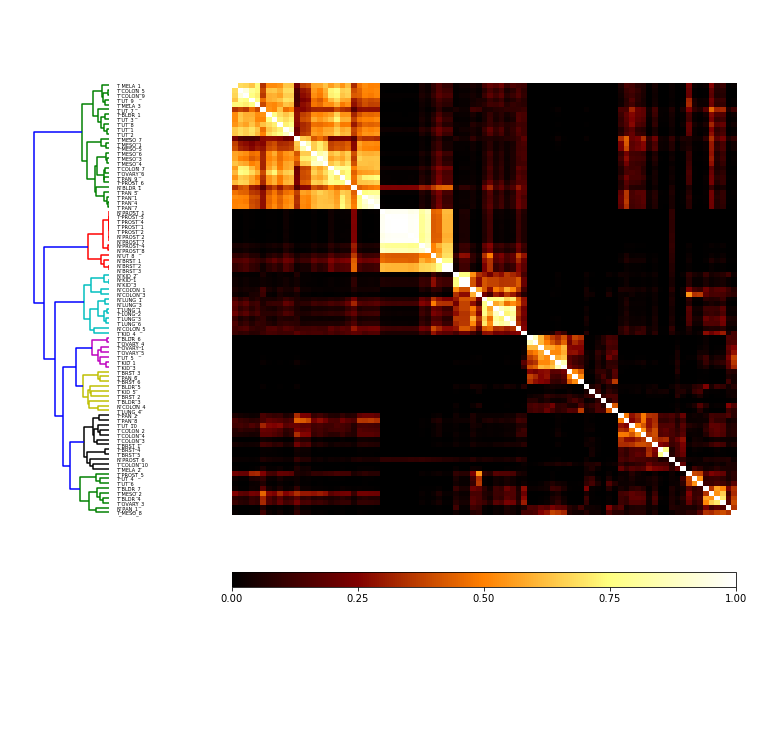

In [5]:
comat = c.co_occurrence_matrix('zscore')
fig = comat.plot(linkage='ward', threshold=1.5)
fig.savefig('comat.eps') 
plt.show()

## How sensitive is feature subsampling to transforming before or after sampling?

In [6]:
#setup a fresh oe.data object from D
dRz = oe.data(D, list(D.columns))


In [ ]:
# select a random susbampling of n_features to cluster num_repeats times
# apply the zscore after random sample is taken
n_features = 100
num_repeats = 2000
names = []
for i in range(0, num_repeats):
    name_base = 'random_'+str(i)
    
    dRz.transform('parent', 'random_subsample', name_base, num_to_sample=n_features)
    name = 'zscore_' + name_base
    dRz.transform(name_base, 'zscore', name)
    names.append(name)
    

In [ ]:
# Cluster all subsamples using agglomerative clustering
cRz = oe.cluster(dRz)
K=15
for name in names:
    cRz.cluster(name, 'agglomerative', name, K)

In [ ]:
comat = cRz.co_occurrence_matrix('parent')
fig = comat.plot(linkage='ward', threshold=1.5)
fig.savefig('comat_subsampleFirst.eps')
plt.show()

## Finish the ensembles using the co-occurrence matrix

In [ ]:
#cut the co-occurrence matrices and compare across the two methods of clustering
c_ComatCut = c.finish_co_occ_linkage(threshold=1.5, linkage='ward')
cMV = c.finish_majority_vote(threshold=0.5)

cRz_ComatCut = cRz.finish_co_occ_linkage(threshold=1.5, linkage='ward')
cRz_cMV = cRz.finish_majority_vote(threshold=0.5)

In [ ]:

#Merge the finished ensembles so that we can simply calculate their similarity by mutual information 
transDictList = c_ComatCut.merge([cMV, cRz_ComatCut, cRz_cMV])
transDictList

In [ ]:
MI = c_ComatCut.MI(MI_type='normalized')
MI.matrix


In the MI matrix above, the non-numbered keys are the parent, which was created by first applying the z-score and then subsampling. It's clear that it makes no difference (or very little difference, depending on the specicific random starting positions) if you z-score before or after subsampling feature dimensions here. Also, both majority vote solutions are similar, although they differ from the solutions built by ward-linking and cutting the co-occurrence matrix. 